In [47]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [48]:
df = pd.read_csv('D:\\Career\\GradProj\\New deal\\Dataset\\parkinson_data.csv')
df.drop('Unnamed: 0', axis = 1,inplace=True)

df.columns = ['Time',
 'AccV',
 'AccML',
 'AccAP',
 'StartHesitation',
 'Turn',
 'Walking',
 'idx',
 'ID',
 'len_df']

In [49]:
df['class'] = np.array(df['Walking'] | df['StartHesitation'] | df['Turn'],dtype = int)



# Compute the mean and standard deviation of the dataset
data = np.asarray(df[['AccV','AccML','AccAP']] , dtype = np.float64)
mean = np.mean(data, axis=0)
std = np.std(data, axis=0)

df[['AccV','AccML','AccAP']] = abs((data - mean) / std)

In [50]:
df = df.groupby(np.arange(len(df)) // (4*128)).mean() 

In [51]:
df

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,idx,len_df,class
0,255.5,0.343536,0.185951,0.709099,0.0,0.000000,0.0,0.0,7400.0,0.000000
1,767.5,0.343984,0.185200,0.707673,0.0,0.000000,0.0,0.0,7400.0,0.000000
2,1279.5,0.576440,0.334005,0.614446,0.0,0.000000,0.0,0.0,7400.0,0.000000
3,1791.5,0.934329,0.794291,0.605298,0.0,0.582031,0.0,0.0,7400.0,0.582031
4,2303.5,1.581461,1.456504,0.926824,0.0,1.000000,0.0,0.0,7400.0,1.000000
...,...,...,...,...,...,...,...,...,...,...
13790,3221.5,0.626441,0.645696,0.320737,0.0,0.000000,0.0,832.0,5158.0,0.000000
13791,3733.5,0.818738,0.909519,0.382190,0.0,0.000000,0.0,832.0,5158.0,0.000000
13792,4245.5,1.209386,0.781171,0.412908,0.0,0.000000,0.0,832.0,5158.0,0.000000
13793,4757.5,1.172291,0.785039,1.106204,0.0,0.000000,0.0,832.0,5158.0,0.000000


<AxesSubplot:>

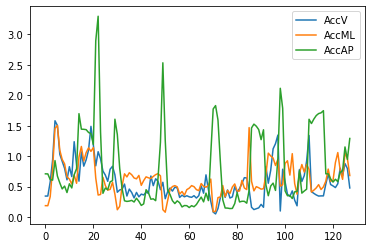

In [52]:
df[['AccV','AccML','AccAP']][0:128].plot()

In [53]:
df[['class']] = df[['class']]>0

df[['normal','fog']] = pd.get_dummies(df['class'], prefix='class')

In [54]:
df

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,idx,len_df,class,normal,fog
0,255.5,0.343536,0.185951,0.709099,0.0,0.000000,0.0,0.0,7400.0,False,1,0
1,767.5,0.343984,0.185200,0.707673,0.0,0.000000,0.0,0.0,7400.0,False,1,0
2,1279.5,0.576440,0.334005,0.614446,0.0,0.000000,0.0,0.0,7400.0,False,1,0
3,1791.5,0.934329,0.794291,0.605298,0.0,0.582031,0.0,0.0,7400.0,True,0,1
4,2303.5,1.581461,1.456504,0.926824,0.0,1.000000,0.0,0.0,7400.0,True,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
13790,3221.5,0.626441,0.645696,0.320737,0.0,0.000000,0.0,832.0,5158.0,False,1,0
13791,3733.5,0.818738,0.909519,0.382190,0.0,0.000000,0.0,832.0,5158.0,False,1,0
13792,4245.5,1.209386,0.781171,0.412908,0.0,0.000000,0.0,832.0,5158.0,False,1,0
13793,4757.5,1.172291,0.785039,1.106204,0.0,0.000000,0.0,832.0,5158.0,False,1,0


In [55]:
x = df[['AccV','AccML','AccAP']]
y = df[['fog','normal']]

In [56]:
# Importing Layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM,Dropout,Dense,BatchNormalization,Input,Bidirectional,Conv1D,MaxPooling1D,Flatten
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split

In [57]:
class ModelCheckpoint_tweaked(tf.keras.callbacks.ModelCheckpoint):
    def __init__(self,
                   filepath,
                   monitor='val_loss',
                   verbose=0,
                   save_best_only=False,
                   save_weights_only=False,
                   mode='auto',
                   save_freq='epoch',
                   options=None,
                   **kwargs):
        
        #Change tf_utils source package.
        from tensorflow.python.keras.utils import tf_utils
        
        super(ModelCheckpoint_tweaked, self).__init__(filepath,
                   monitor,
                   verbose,
                   save_best_only,
                   save_weights_only,
                   mode,
                   save_freq,
                   options,
                   **kwargs)

In [67]:
rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor="accuracy",factor=0.5,patience=5,)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=30)
checkpointer = ModelCheckpoint_tweaked(filepath='best.hdf5', verbose=0, save_best_only=True)
csv_logger = tf.keras.callbacks.CSVLogger("model_history_log.csv", append=True)

In [68]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.50)

model_aug = Sequential([
    Input((None,3)),
    Dense(100),
    Dropout(0.1),
    Dense(100),
    Dropout(0.1),
    Dense(100),
    Dropout(0.1),
    Dense(2, activation = 'softmax') 
])

model_aug.compile(  optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),#, clipvalue=0.5),
                loss='categorical_crossentropy', 
                metrics=['accuracy'],
                
                )

model_aug.summary()
tf.config.list_physical_devices('GPU')

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, None, 100)         400       
                                                                 
 dropout_15 (Dropout)        (None, None, 100)         0         
                                                                 
 dense_20 (Dense)            (None, None, 100)         10100     
                                                                 
 dropout_16 (Dropout)        (None, None, 100)         0         
                                                                 
 dense_21 (Dense)            (None, None, 100)         10100     
                                                                 
 dropout_17 (Dropout)        (None, None, 100)         0         
                                                                 
 dense_22 (Dense)            (None, None, 2)          

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [69]:
model_aug.fit(x_train, y_train, batch_size = 256, epochs = 200, callbacks = [rlr,earlystop,checkpointer,csv_logger],validation_data=(x_val,y_val))

Epoch 1/200
49/49 [==============================] - 1s 12ms/step - loss: 0.6483 - accuracy: 0.6272 - val_loss: 0.6314 - val_accuracy: 0.6406 - lr: 0.0010
Epoch 2/200
49/49 [==============================] - 0s 7ms/step - loss: 0.6393 - accuracy: 0.6463 - val_loss: 0.6304 - val_accuracy: 0.6536 - lr: 0.0010
Epoch 3/200
49/49 [==============================] - 0s 6ms/step - loss: 0.6377 - accuracy: 0.6507 - val_loss: 0.6342 - val_accuracy: 0.6420 - lr: 0.0010
Epoch 4/200
49/49 [==============================] - 0s 7ms/step - loss: 0.6364 - accuracy: 0.6511 - val_loss: 0.6292 - val_accuracy: 0.6652 - lr: 0.0010
Epoch 5/200
49/49 [==============================] - 0s 6ms/step - loss: 0.6367 - accuracy: 0.6544 - val_loss: 0.6308 - val_accuracy: 0.6551 - lr: 0.0010
Epoch 6/200
49/49 [==============================] - 0s 7ms/step - loss: 0.6353 - accuracy: 0.6510 - val_loss: 0.6309 - val_accuracy: 0.6522 - lr: 0.0010
Epoch 7/200
49/49 [==============================] - 0s 9ms/step - loss: 0.

In [66]:
model_aug.evaluate(x_test,y_test)

y_pred = model_aug.predict(x_test)

22/22 [==============================] - 0s 3ms/step


In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model_aug, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
from visualkeras import layered_view
layered_view(model_aug)

In [70]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.50)

model_aug = Sequential([
    Input((None,3)),
    Dense(100),
    Dropout(0.1),
    Dense(100),
    Dropout(0.1),
    Dense(100),
    Dropout(0.1),
    Dense(100),
    Dropout(0.1),
    Dense(2, activation = 'softmax') 
])

model_aug.compile(  optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),#, clipvalue=0.5),
                loss='categorical_crossentropy', 
                metrics=['accuracy'],
                
                )

model_aug.summary()
tf.config.list_physical_devices('GPU')

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, None, 100)         400       
                                                                 
 dropout_18 (Dropout)        (None, None, 100)         0         
                                                                 
 dense_24 (Dense)            (None, None, 100)         10100     
                                                                 
 dropout_19 (Dropout)        (None, None, 100)         0         
                                                                 
 dense_25 (Dense)            (None, None, 100)         10100     
                                                                 
 dropout_20 (Dropout)        (None, None, 100)         0         
                                                                 
 dense_26 (Dense)            (None, None, 100)        

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [71]:
model_aug.fit(x_train, y_train, batch_size = 256, epochs = 200, callbacks = [rlr,earlystop,checkpointer,csv_logger],validation_data=(x_val,y_val))

Epoch 1/200
49/49 [==============================] - 1s 13ms/step - loss: 0.6609 - accuracy: 0.6097 - val_loss: 0.6421 - val_accuracy: 0.6493 - lr: 0.0010
Epoch 2/200
49/49 [==============================] - 0s 7ms/step - loss: 0.6393 - accuracy: 0.6444 - val_loss: 0.6357 - val_accuracy: 0.6623 - lr: 0.0010
Epoch 3/200
49/49 [==============================] - 0s 8ms/step - loss: 0.6379 - accuracy: 0.6491 - val_loss: 0.6342 - val_accuracy: 0.6638 - lr: 0.0010
Epoch 4/200
49/49 [==============================] - 0s 7ms/step - loss: 0.6389 - accuracy: 0.6508 - val_loss: 0.6378 - val_accuracy: 0.6594 - lr: 0.0010
Epoch 5/200
49/49 [==============================] - 0s 7ms/step - loss: 0.6382 - accuracy: 0.6492 - val_loss: 0.6338 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 6/200
49/49 [==============================] - 0s 7ms/step - loss: 0.6377 - accuracy: 0.6491 - val_loss: 0.6389 - val_accuracy: 0.6565 - lr: 0.0010
Epoch 7/200
49/49 [==============================] - 0s 8ms/step - loss: 0.

KeyboardInterrupt: 

In [74]:
y['fog'].sum()/y['normal'].sum()

0.6070596458527493